In [2]:
%matplotlib inline

In [3]:
from tqdm.notebook import tqdm

In [4]:
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

import torchmetrics

import lightly

import matplotlib.pyplot as plt
import numpy as np

/home/shatz/miniconda3/envs/morebetter2/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA

In [6]:
# data params
num_workers = 6
batch_size = 1

In [7]:
path_to_train = './data/cifar10_lightly/train/'
path_to_test = './data/cifar10_lightly/test/'

In [8]:
# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

In [9]:
val_dataloader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

@TODO: make data for classifier and for moco

... will probably have to make a custom loader that makes both something for moco and something for classifier

# MOCO data

# Classifier

In [9]:
# model params
n_classes=10
pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.64-val_acc=0.80.ckpt"

In [10]:
from plr18 import plr18

In [11]:
model = plr18().load_from_checkpoint(pretrained_model);

In [12]:
model.to(device);
model.eval();

# Defense model

In [1]:
class MocoModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = lightly.models.ResNetGenerator('resnet-18', 1, num_splits=8)
        backbone = nn.Sequential(
            *list(resnet.children())[:-1],
            nn.AdaptiveAvgPool2d(1),
        )

        # create a moco based on ResNet
        self.resnet_moco = \
            lightly.models.MoCo(backbone, num_ftrs=512, m=0.99, batch_shuffle=True)

        # create our loss with the optional memory bank
        self.criterion = lightly.loss.NTXentLoss(
            temperature=0.1,
            memory_bank_size=memory_bank_size)

    def forward(self, x):
        self.resnet_moco(x)

    # We provide a helper method to log weights in tensorboard
    # which is useful for debugging.
    def custom_histogram_weights(self):
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(
                name, params, self.current_epoch)

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        y0, y1 = self.resnet_moco(x0, x1)
        loss = self.criterion(y0, y1)
        self.log('train_loss_ssl', loss)
        return loss

    def training_epoch_end(self, outputs):
        self.custom_histogram_weights()


    def configure_optimizers(self):
        optim = torch.optim.SGD(self.resnet_moco.parameters(), lr=6e-2,
                                momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


NameError: name 'pl' is not defined

# Experiment

In [13]:
seed = 1
max_epochs = 150
batch_limit = 500

In [14]:
epsilons = [0, 0.001, 0.002, 0.003, 0.004, 0.008, 0.01, .05, .1, .15, .2,]

In [15]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [16]:
def test( model, test_loader, epsilon, batch_limit=1000):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for (idx, (data, target, _)) in enumerate(tqdm(test_loader)):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        if idx > batch_limit:
            break

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [17]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, val_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/shatz/miniconda3/envs/morebetter2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epsilon: 0	Test Accuracy = 8022 / 10000 = 0.8022


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.001	Test Accuracy = 7483 / 10000 = 0.7483


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.002	Test Accuracy = 6908 / 10000 = 0.6908


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.003	Test Accuracy = 6375 / 10000 = 0.6375


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.004	Test Accuracy = 5826 / 10000 = 0.5826


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.008	Test Accuracy = 3975 / 10000 = 0.3975


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.01	Test Accuracy = 3346 / 10000 = 0.3346


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.05	Test Accuracy = 661 / 10000 = 0.0661


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.1	Test Accuracy = 606 / 10000 = 0.0606


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.15	Test Accuracy = 602 / 10000 = 0.0602


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.2	Test Accuracy = 592 / 10000 = 0.0592


In [18]:
## SANITY CHECK CODE in case the above doesnt work as expected ##

# correct = 0
# for d, t, _ in tqdm(test_loader):
#     data, target = d.to(device), t.to(device)
#     out = model(data).max(1, keepdim=True)[1]
# #     print('out:', out)
# #     print('target:', target)
    
#     if out.item() == target.item():
#         correct += 1
# print('CORRECT:', correct)


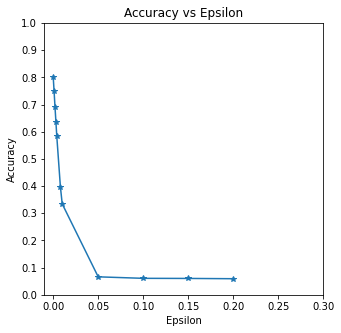

In [23]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Sample Adversarial Examples
~~~~~~~~~~~~~~~~~~~~~~~~~~~

Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degredation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.




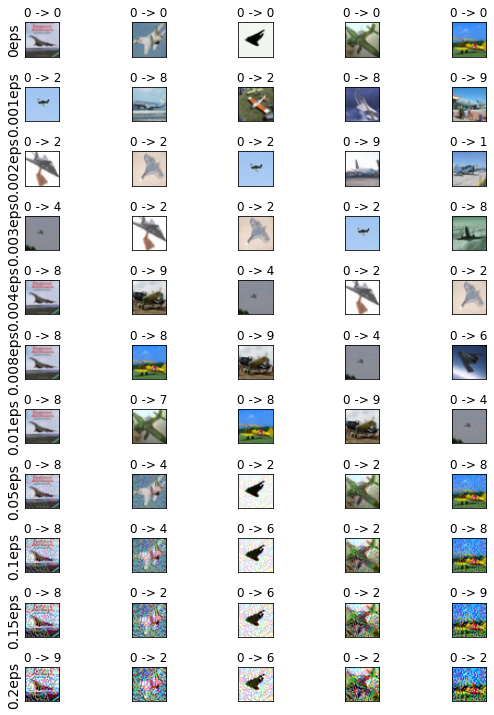

In [29]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("{}eps".format(epsilons[i]), fontsize=14) # eps 
        orig,adv,ex = examples[i][j]
        ex = np.moveaxis(ex, 0, -1)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()